## This notebook will look at the "global" structure of the loss landscape by plotting how loss changes as we move along a linear line from initial parameters to trained parameters of a deep network

In [1]:
from itertools import islice
from copy import deepcopy
import random

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torchvision

In [2]:
########### Set Device ############
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
torch.set_default_dtype(dtype)
print("Using device: {}".format(device))

Using device: cuda:0


In [3]:
train = torchvision.datasets.MNIST(root="/tmp", train=True, transform=torchvision.transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST(root="/tmp", train=False, transform=torchvision.transforms.ToTensor(), download=True)

In [4]:
def compute_accuracy(network, dataset, device, N=2000, batch_size=50):
    with torch.no_grad():
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        correct = 0
        total = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            logits = network(x.to(device))
            predicted_labels = torch.argmax(logits, dim=1)
            correct += torch.sum(predicted_labels == labels.to(device))
            total += x.size(0)
        return (correct / total).item()

def compute_loss(network, loss_fn, dataset, device, N=2000, batch_size=50):
    with torch.no_grad():
        dataset_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
        loss = 0
        total = 0
        for x, labels in islice(dataset_loader, N // batch_size):
            logits = network(x.to(device))
            loss += loss_fn(logits, labels.to(device))
            total += x.size(0)
        return (loss / total).item()

### Train our first network and create interpolation plot

In [5]:
network = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
).to(device)

initial_params = dict((name, param.detach().cpu().numpy()) for name, param in network.named_parameters())

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=1e-1)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train, batch_size=200, shuffle=True)

n_steps = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

i = 0
for epoch in tqdm(range(50)):
    for x, label in train_loader:
        if i % 200 == 0:
            with torch.no_grad():
                n_steps.append(i)
                train_losses.append(compute_loss(network, loss_fn, train, device, N=5000, batch_size=500))
                test_losses.append(compute_loss(network, loss_fn, test, device, N=5000, batch_size=500))
                train_accuracies.append(compute_accuracy(network, train, device, N=5000, batch_size=500))
                test_accuracies.append(compute_accuracy(network, test, device, N=5000, batch_size=500))
        optimizer.zero_grad()
        loss = loss_fn(network(x.to(device)), label.to(device))
        loss.backward()
        optimizer.step()
        i += 1
        
final_params = dict((name, param.detach().cpu().numpy()) for name, param in network.named_parameters())
            

  0%|          | 0/50 [00:00<?, ?it/s]

In [6]:
alphas = np.linspace(0, 2, 500)
interpolated_train_losses = []

for alpha in tqdm(alphas):
    network = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 100),
        nn.ReLU(),
        nn.Linear(100, 10)
    ).to(device)
    for name, param in network.named_parameters():
        interpolated_param = (1 - alpha) * initial_params[name] + alpha * final_params[name]
        param.data = torch.tensor(interpolated_param).to(dtype).to(device)
    interpolated_train_losses.append(compute_loss(network, loss_fn, train, device, N=60000, batch_size=500))


  0%|          | 0/500 [00:00<?, ?it/s]

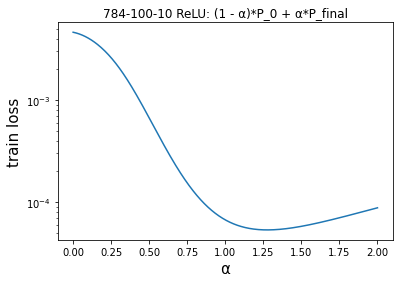

In [9]:
plt.plot(alphas, interpolated_train_losses)
plt.yscale('log')
plt.xlabel("α", fontsize=15)
plt.ylabel("train loss", fontsize=15)
plt.title("784-100-10 ReLU: (1 - α)*P_0 + α*P_final")
plt.savefig("../figures/loss-interpolation-relu784-100-10-logscale-beyond1alpha.jpg", dpi=300)

### Save run data

In [17]:
import pickle
with open("interpolating-parameters-loss1.pkl", "wb") as f:
    pickle.dump((initial_params, n_steps, train_losses, test_losses, train_accuracies, test_accuracies, final_params, alphas, interpolated_train_losses), f)
    

### Do the same with a deeper Tanh network

In [18]:
network = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 100),
    nn.Tanh(),
    nn.Linear(100, 10)
).to(device)

initial_params = dict((name, param.detach().cpu().numpy()) for name, param in network.named_parameters())

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr=1e-1)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train, batch_size=200, shuffle=True)

n_steps = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

i = 0
for epoch in tqdm(range(80)):
    for x, label in train_loader:
        if i % 200 == 0:
            with torch.no_grad():
                n_steps.append(i)
                train_losses.append(compute_loss(network, loss_fn, train, device, N=5000, batch_size=500))
                test_losses.append(compute_loss(network, loss_fn, test, device, N=5000, batch_size=500))
                train_accuracies.append(compute_accuracy(network, train, device, N=5000, batch_size=500))
                test_accuracies.append(compute_accuracy(network, test, device, N=5000, batch_size=500))
        optimizer.zero_grad()
        loss = loss_fn(network(x.to(device)), label.to(device))
        loss.backward()
        optimizer.step()
        i += 1
        
final_params = dict((name, param.detach().cpu().numpy()) for name, param in network.named_parameters())
            

  0%|          | 0/80 [00:00<?, ?it/s]

In [19]:
alphas = np.linspace(0, 2, 500)
interpolated_train_losses = []

for alpha in tqdm(alphas):
    network = nn.Sequential(
        nn.Flatten(),
        nn.Linear(28*28, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 100),
        nn.Tanh(),
        nn.Linear(100, 10)
    ).to(device)
    for name, param in network.named_parameters():
        interpolated_param = (1 - alpha) * initial_params[name] + alpha * final_params[name]
        param.data = torch.tensor(interpolated_param).to(dtype).to(device)
    interpolated_train_losses.append(compute_loss(network, loss_fn, train, device, N=60000, batch_size=500))


  0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
import pickle
with open("interpolating-parameters-loss2.pkl", "wb") as f:
    pickle.dump((initial_params, n_steps, train_losses, test_losses, train_accuracies, test_accuracies, final_params, alphas, interpolated_train_losses), f)
    

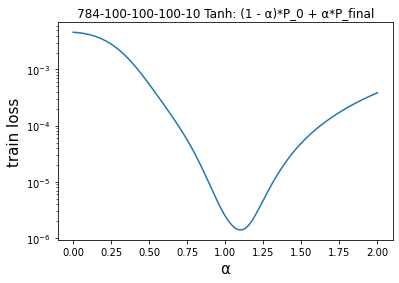

In [23]:
plt.plot(alphas, interpolated_train_losses)
plt.yscale('log')
plt.xlabel("α", fontsize=15)
plt.ylabel("train loss", fontsize=15)
plt.title("784-100-100-100-10 Tanh: (1 - α)*P_0 + α*P_final")
plt.savefig("../figures/loss-interpolation-tanh784-100-100-100-10-logscale-beyond1alpha.jpg", dpi=300)